<a href="https://colab.research.google.com/github/17092003vamsi/HUNTERs/blob/main/HUNTER_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


✅ Training Accuracy: 0.868
✅ Validation Accuracy: 0.646
✅ Testing Accuracy: 0.646

✅ Cross-validation Accuracy scores: [0.72727273 0.67676768 0.45454545 0.26262626 0.35714286]
✅ Mean CV Accuracy: 0.496

✅ Classification Report
              precision    recall  f1-score   support

           0       0.38      0.48      0.43        27
           1       0.78      0.71      0.74        72

    accuracy                           0.65        99
   macro avg       0.58      0.59      0.59        99
weighted avg       0.67      0.65      0.66        99



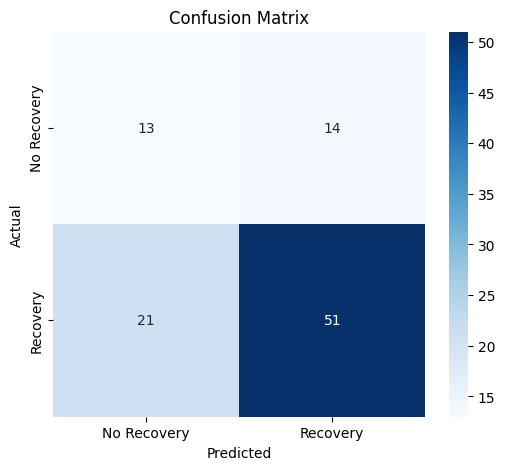


✅ ROC-AUC: 0.655


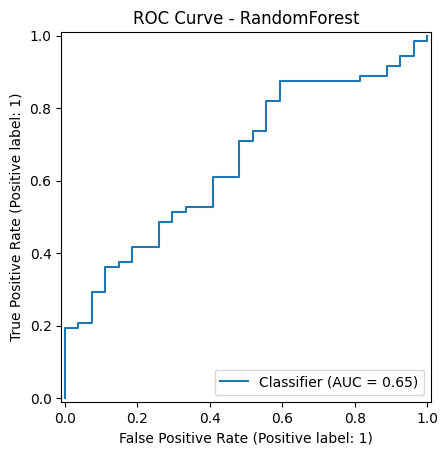

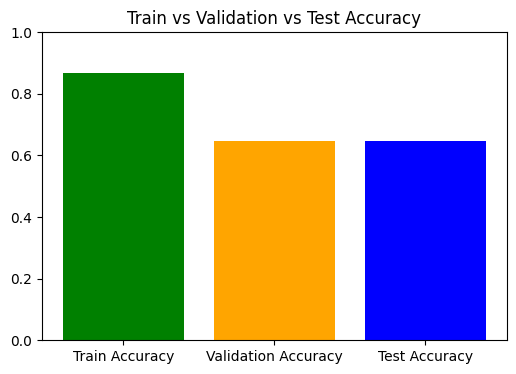

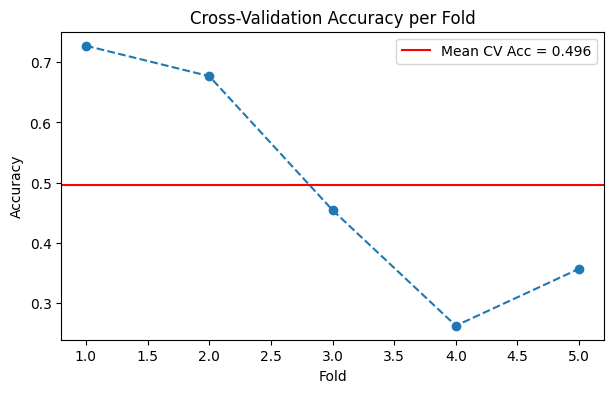


✅ Top 10 Feature Importances
                                              Feature  Importance
0                                                 Age    0.500403
1             Baseline Score on House–Brackmann scale    0.184399
12                           Received Prednisolone=No    0.038469
3                                            Sex=Male    0.036440
13                          Received Prednisolone=Yes    0.036253
4   Time between onset of symptoms and start of tr...    0.036063
2                                          Sex=Female    0.035313
7   Time between onset of symptoms and start of tr...    0.031716
8                   Treatment Group=Acyclovir–Placebo    0.022695
11               Treatment Group=Prednisolone–Placebo    0.018103


/tmp/ipython-input-1552707317.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=fi_df.head(10), palette="viridis")


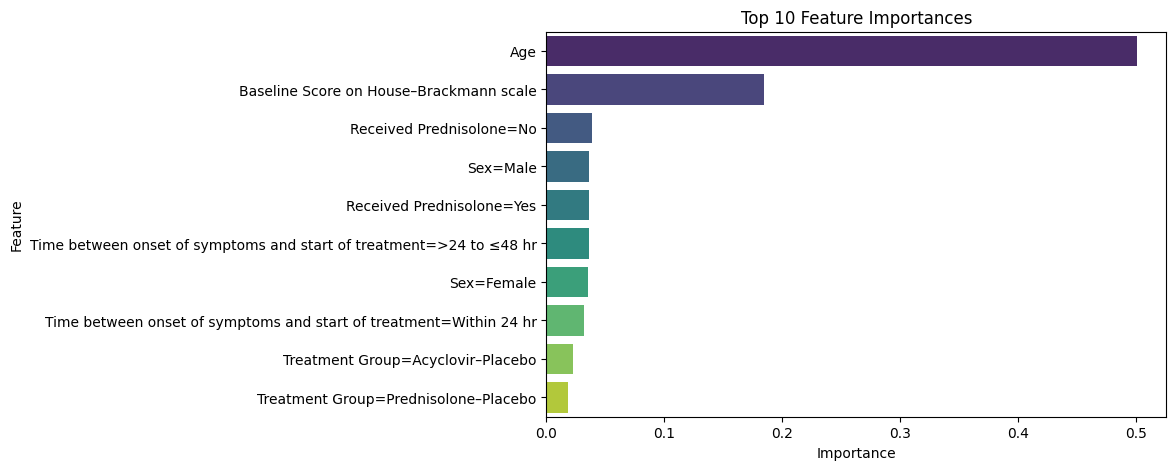


💾 Model saved as bells_palsy_rf_model.joblib


In [3]:
# ✅ Install required packages if missing
# !pip install pandas numpy scikit-learn matplotlib seaborn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import joblib



# 1. Load Dataset


df = pd.read_csv("Bells Palsy Clinical Trial.csv")

# Target column
target_col = "Full Recovery in 3 Months"   # 👉 change to "Full Recovery in 9 Months" if needed

# Features to use (baseline only, avoids leakage)
features = [
    'Sex',
    'Age',
    'Baseline Score on House–Brackmann scale',
    'Time between onset of symptoms and start of treatment',
    'Treatment Group',
    'Received Prednisolone',
    'Received Acyclovir',
]

X = df[features].copy()
y = df[target_col].map({"Yes": 1, "No": 0})


# 2. Preprocessing


numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# 3. Model

model = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced",
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])


# 4. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 5. Fit Model

clf.fit(X_train, y_train)


# 6. Accuracy (Training, Validation, Testing)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_test, y_test_pred)   # same as test accuracy
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n✅ Training Accuracy: {train_acc:.3f}")
print(f"✅ Validation Accuracy: {val_acc:.3f}")
print(f"✅ Testing Accuracy: {test_acc:.3f}")


# 7. Cross-validation (to show fold accuracy)

cv_scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
print(f"\n✅ Cross-validation Accuracy scores: {cv_scores}")
print(f"✅ Mean CV Accuracy: {cv_scores.mean():.3f}")


# 8. Classification Report & Confusion Matrix

print("\n✅ Classification Report")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Recovery","Recovery"],
            yticklabels=["No Recovery","Recovery"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 9. ROC Curve

y_proba = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\n✅ ROC-AUC: {roc_auc:.3f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - RandomForest")
plt.show()


# 10. Accuracy Graph (Train vs Test)

plt.figure(figsize=(6,4))
plt.bar(["Train Accuracy", "Validation Accuracy", "Test Accuracy"],
        [train_acc, val_acc, test_acc], color=["green","orange","blue"])
plt.ylim(0,1)
plt.title("Train vs Validation vs Test Accuracy")
plt.show()


# 11. CV Accuracy Plot

plt.figure(figsize=(7,4))
plt.plot(range(1, len(cv_scores)+1), cv_scores, marker="o", linestyle="--")
plt.axhline(y=cv_scores.mean(), color="r", linestyle="-",
            label=f"Mean CV Acc = {cv_scores.mean():.3f}")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy per Fold")
plt.legend()
plt.show()


# 12. Feature Importances

def get_feature_names(preprocess, numeric_cols, categorical_cols):
    feat_names = numeric_cols.copy()
    ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
    for col, cats in zip(categorical_cols, ohe.categories_):
        feat_names.extend([f"{col}={cat}" for cat in cats])
    return feat_names

pre = clf.named_steps["preprocess"]
rf = clf.named_steps["model"]
feat_names = get_feature_names(pre, numeric_cols, categorical_cols)

importances = rf.feature_importances_
fi_df = pd.DataFrame({"Feature": feat_names, "Importance": importances})
fi_df = fi_df.sort_values("Importance", ascending=False)

print("\n✅ Top 10 Feature Importances")
print(fi_df.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(10), palette="viridis")
plt.title("Top 10 Feature Importances")
plt.show()

# 13. Save Model

joblib.dump(clf, "bells_palsy_rf_model.joblib")
print("\n💾 Model saved as bells_palsy_rf_model.joblib")
